# Logistic Regression

## Team Members

- Balasundaram Avudai Nayagam

- Muthu Priya Shanmugakani Velsamy

- Sushma Keddallu Suriyaprakash

- Srinath Muralinathan


## Introduction to Logistic Regression
Logistic regression or logistic model is one of the statistical technique used in predictive analysis for "Binary Classification". It is used to model the probability of a certain class or event existing such as yes/no, pass/fail, win/lose, etc., It gives us a discrete binary outcome 0 or 1.

In this assignment we are training and testing a model using logistic regression and measuring its performance using ROC and AUC metrics.

### ROC Curve
ROC or Receiver Operating Characteristics Curve is a probability curve. The ROC curve is plotted with TPR (True Positive Rate) against the FPR (False Positive Rate).

### AUC 
AUC or Area Under the Curve is the region below the ROC curve. It is also written as AUROC (Area Under the Receiver Operating Characteristics). It represents the measure of separability among the classes. Higher the AUC value, better the model is at predicting 0s as 0s and 1s as 1s.

### Confusion Matrix
Confusion matrix is a matrix or a table that shows the performance result of the classification model. It will be plotted as Actual 0s and 1s vs Predicted 0s and 1s. Also known as Error Matrix.

TP is the number of true positives
FP is the number of false positives.
FN is the number of false negatives.
TN is the number of true negatives.

#### Formulas
- Recall = TP / (TP + FN)
- Precision = TP / (TP + FP)
- F1 score = (2* Recall * Precision) / (Recall + Presision)
- Accuracy = (TP + TN) / (TP + TN + FP + FN)

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
pd.options.display.max_columns = None
import missingno as msno
import seaborn as sb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from imblearn.over_sampling import SMOTE

In [31]:
data = pd.read_csv('/Users/sushmarameshraj/Downloads/bank-marketing/bank-additional-full.csv', sep=';')

#data=data.drop(['duration'],axis=1)
print(data.shape)
data.head()

(41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


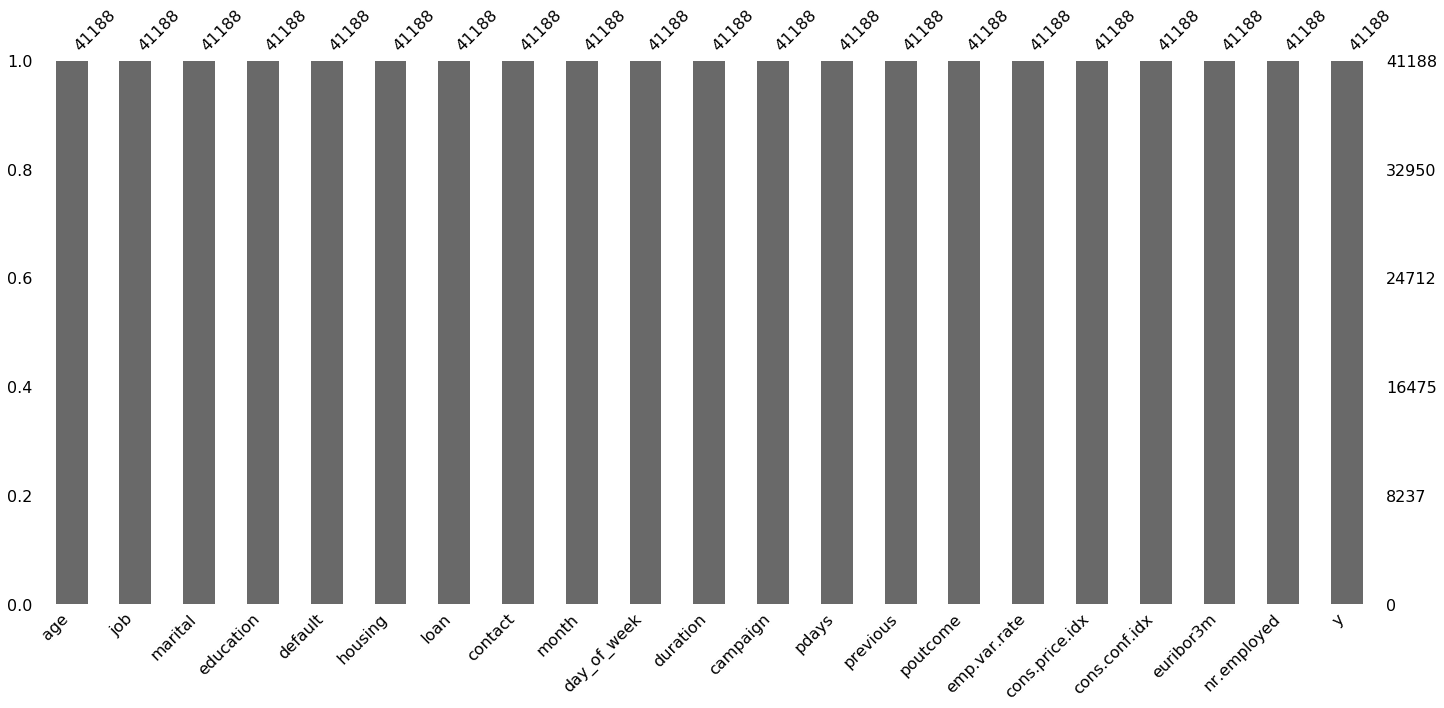

In [32]:
#Checking for missing values and plotting it in a bar chart
msno.bar(data)

In [33]:
X = data.drop('y', axis=1)
y = data['y']

# Map response variable to integers 0,1.

y = pd.Series(np.where(y.values == 'yes',1,0), y.index)

y.value_counts()

0    36548
1     4640
dtype: int64

### Label Encoding 
- Label encoding is used in order to run a logistic regression on this data. We are converting all non-numeric features into numeric features. Then, We are setting the order of the labels for categorical columns. 

### One-hot Encoding

- One hot encoding is used, where a new feature column is created for each unique value in the feature column. Here, using cat.codes we set the order and one hot is used to determine if the value is 1 or 0 based on the value present for that observation. 

- Finally, Label encoding is used in cases of low cardinality data.

In [34]:
# Label encode categorical variables.

label_encoder = LabelEncoder()
mappings = []

# Desired label orders for categorical columns.

educ_order = ['unknown', 'illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'professional.course', 'university.degree']
month_order = ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
day_order = ['mon', 'tue', 'wed', 'thu', 'fri']

# using cat.codes for order, one hot for high cardinality and weak case of cardinality.

def ordered_labels(data, col, order):
    data[col] = data[col].astype('category')
    data[col] = data[col].cat.reorder_categories(order, ordered=True)
    data[col] = data[col].cat.codes.astype(int)

# Use dummy variables for occupation
X = pd.concat([X, pd.get_dummies(X['job'])],axis=1).drop('job',axis=1)

# Use ordered cat.codes for days, months, and education
ordered_labels(X, 'education', educ_order)
ordered_labels(X, 'month', month_order)
ordered_labels(X, 'day_of_week', day_order)

# Same label encoding for rest since low cardinality
for i, col in enumerate(X):
    if X[col].dtype == 'object':
        X[col] = label_encoder.fit_transform(np.array(X[col].astype(str)).reshape((-1,)))
        mappings.append(dict(zip(label_encoder.classes_, range(1, len(label_encoder.classes_)+1))))

X.head()


,age,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown
0,56,1,2,0,0,0,1,2,0,261,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0,0,0,1,0,0,0,0,0,0,0,0
1,57,1,5,1,0,0,1,2,0,149,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0
2,37,1,5,0,2,0,1,2,0,226,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0
3,40,1,3,0,0,0,1,2,0,151,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,1,0,0,0,0,0,0,0,0,0,0,0
4,56,1,5,0,0,2,1,2,0,307,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0


### Data Partitioning

The feature and label sets are split into train and test subsets

In [35]:
# Split feature and label sets to train and data sets.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((32950, 31), (8238, 31), (32950,), (8238,))

### Normalization

To normalize the data, we use MinMaxScaler and constrain the range of values to be between 0 and 1.

In [36]:
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Random Forest Classifier

Random forest model is used in order to obtain improved performance and obtain the model accuracy value. To improve the model by tuning the hyperparameters of the model,we define a “grid” of parameters that we would want to test out in the model.Both LogisticRegression() and RandomForestClassifier() are used in two dictionaries. 

- The first dictionary (LogisticRegression()) includes type of regularization, size of penalty, and type of solver used.
- The second dictionary (RandomForestClassifier()) includes the number of estimators and the maximum number of features used in the model.

Using GridSearchCV, we select the best model.Finally, we fit the resulting models. 

In [37]:
# Create first pipeline for base without reducing features.

pipe = Pipeline([('classifier' , RandomForestClassifier())])
# pipe = Pipeline([('classifier', RandomForestClassifier())])

# Create param grid.

param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear']},
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(10,101,10)),
    'classifier__max_features' : list(range(6,32,5))}
]

# Create grid search object

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

# Fit on data

best_clf = clf.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   56.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 11.0min finished


In [38]:
best_clf.best_estimator_.get_params()['classifier']

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=11, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### Normalized model accuracy

In [50]:
print('Normalized Model accuracy is',best_clf.score(X_test, y_test))

Normalized Model accuracy is 0.9084729303228939


### Receiver Operating Characteristics Curve (ROC)

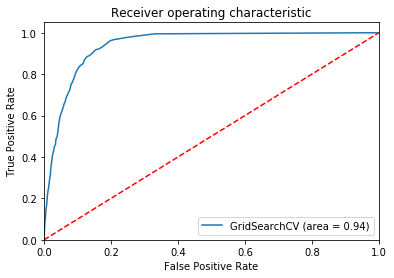

In [40]:
probs = best_clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='GridSearchCV (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [41]:
roc_auc

0.9403387247039954

In [54]:
classes = best_clf.predict(X_test)
    
accuracy = metrics.accuracy_score(classes, y_test)
    
balanced_accuracy = metrics.balanced_accuracy_score(classes, y_test)

precision = metrics.precision_score(classes, y_test)
    
average_precision = metrics.average_precision_score(classes, y_test)
    
f1_score = metrics.f1_score(classes, y_test)
    
recall = metrics.recall_score(classes, y_test)

print (accuracy , balanced_accuracy, precision, average_precision, f1_score, recall, roc_auc)

0.9084729303228939 0.7698490910887177 0.6368534482758621 0.4240123242966034 0.6105371900826446 0.5863095238095238 0.9400275366762585


### Classification Model Report

In [43]:
print(metrics.classification_report(classes, y_test))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      7495
           1       0.50      0.62      0.55       743

    accuracy                           0.91      8238
   macro avg       0.73      0.78      0.75      8238
weighted avg       0.92      0.91      0.91      8238



### Resampling the data

We again resample the data using SMOTE. Repeating the same fit on resampled data yield the same accuracy and classification report, however, it took up to 30 minutes to run.

In [44]:
# Rerunning above with resampled data

sm = SMOTE(random_state = 2)
X_train_res, y_tr ain_res = sm.fit_sample(X_train, y_train.ravel())

best_clf = clf.fit(X_train_res, y_train_res)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 30.5min finished


In [45]:
best_clf.best_estimator_.get_params()['classifier']

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=6, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### Resampled model accuracy

In [51]:
print('Resampled Model accuracy is',best_clf.score(X_test, y_test))


Resampled Model accuracy is 0.9084729303228939


### Receiver Operating Characteristics Curve (ROC)

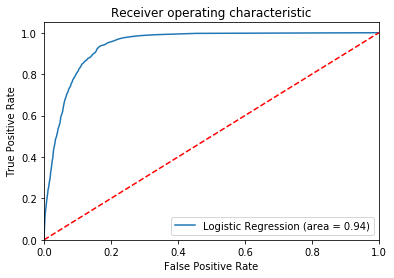

In [47]:
probs = best_clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### Final Classification Model Report

In [48]:
print(metrics.classification_report(classes, y_test))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      7495
           1       0.50      0.62      0.55       743

    accuracy                           0.91      8238
   macro avg       0.73      0.78      0.75      8238
weighted avg       0.92      0.91      0.91      8238



## Observation
From the above results, it is evident that the model trained and tested using the logistic regression technique is predicting  the results well in most of the scenarios. This is also proven by the AUC values. As we discussed earlier, "Higher the AUC value, better the model is at predicting 0s as 0s and 1s as 1s."

## Conclusion
As a part of this assignment, we have better understood the concepts behind the logistic regression technique as well as, we learnt more about Confusion matrix, ROC curve and AUC metrics.